# Variant Interpretation Benchmark
This notebook shows results reported in paper **A Machine Learning approach to support ACMG/AMP-based Genomic Variant Classification** by G. Nicora et al.


*Genomic variant interpretation is a critical step of the diagnostic procedure, often supported by the application of tools that may predict the damaging impact of each variant or provide a guidelines-based classification.
We propose the application of Machine Learning methodologies, in particular Logistic Regression, to support variant classification and prioritization. Our approach combines ACMG/AMP guidelines for germline variant interpretation as well as variant annotation features and provides a probabilistic score of pathogenicity, thus supporting the prioritization and classification of variants that would be interpreted as uncertain by the ACMG/AMP guidelines. We compared different approaches in terms of variant prioritization and classification on different datasets, showing that our data-driven approach is able to solve more VUS cases in comparison with guidelines-based approaches and in silico prediction tools.*

Data are available in figshare

To open with Colab from Github, follow instructions in https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb


## Aim
Compare performance of different tools in variant classification and prioritization. In particular, we compared:
- Logistic Regression on ACMG/AMP criteria (LR-A)
- Logistic Regression on ACMG/AMP criteria and annotation features (LR-B)
- VVP [1]
- CADD [2]
- eVAI Pathogenicity Score (PS) [3]
- Bayesian score based on ACMG/AMP guidelines [5]
 
 **Requirements**
- Pytho 3.6.9
- Pandas 0.24.2
- scikit-learn 0.21.3


In [11]:
from google.colab import drive
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH, force_remount=True)
# use your path here 
ROOT_PATH += '/My Drive/Dottorato/Variant_Interpretation/eVAI/evai_ml/'

Mounted at /content/drive


In [12]:
!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default


# Dependecies
!pip install pandas==0.24.2
!pip install numpy==1.17.4
!pip install scikit-learn==0.21.3
!pip install scipy==1.4.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth                    #

!cp "/content/drive/My Drive/Dottorato/Variant_Interpretation/eVAI/evai_ml/utils.py" .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!python --version

Python 3.7.13


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import *
from collections import Counter
from sklearn.model_selection import train_test_split

In [15]:
from utils import *

# Function to calculate the eVai pathogenicity score (PS)
def calc_patho_score(dataset):
    acmg_col = ['nPVS', 'nPS', 'nPM', 'nPP', 'nBA', 'nBS', 'nBP']
    return 4*dataset.nPVS+3*dataset.nPS+2*dataset.nPM+dataset.nPP-1.5*dataset.nBA-dataset.nBS-0.5*dataset.nBP

## Logistic Regression Training

ML training is performed based on benign and pathogenic variants reported without conflicting interpretation in CLINVITAE (http://clinvitae.invitae.com) up to 2017 (ClinVar variants were removed). 60% of the dataset is used for model selection and training (*Train set*), 30% is used to select the best classification threshold to maximize precision (*Probability tuning set*), 10% (*Test set*) is used to evaluate the performance also in comparison with the eVai Pathogenicity Score (PS) [3].

In [54]:
# Loading variants in the Training set, Probability tuning set and Test set
train_path = ROOT_PATH + 'pubblication_data/subset/train/2017_03_ClinvitaeTrueClass_Train_Subset.tsv'
test_path = ROOT_PATH + 'pubblication_data/subset/test/2017_03_ClinvitaeTrueClass_Test_Subset.tsv'
tuning_path = ROOT_PATH + 'pubblication_data/subset/tuning/2017_03_ClinvitaeTrueClass_Tuning_Subset.tsv'

train_var = pd.read_csv(train_path, sep='\t')
tuning_var = pd.read_csv(tuning_path, sep='\t')
test_var = pd.read_csv(test_path, sep='\t')

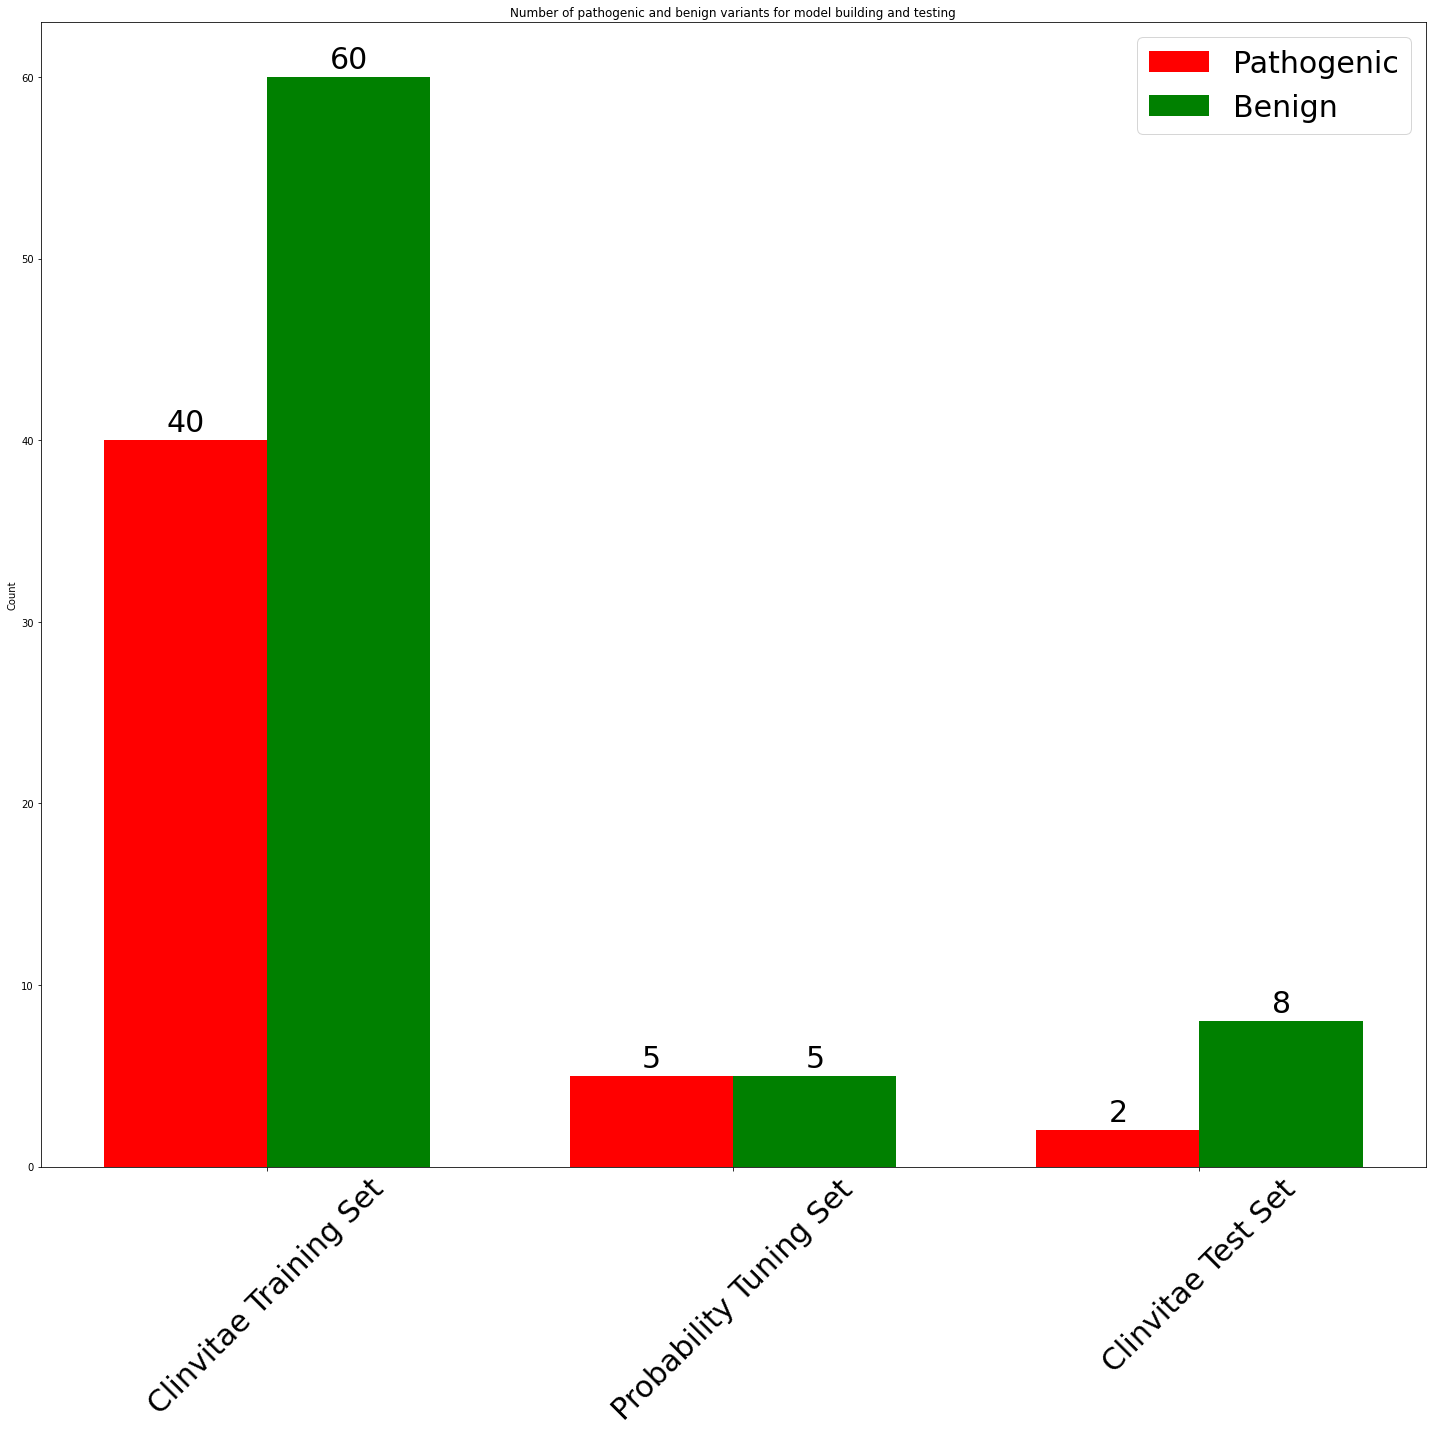

In [55]:
labels = ['Clinvitae Training Set', 'Probability Tuning Set', 'Clinvitae Test Set']
patho_count = [train_var[train_var.FINAL_CLASSIFICATION=='Pathogenic'].shape[0],
               tuning_var[tuning_var.FINAL_CLASSIFICATION=='Pathogenic'].shape[0],
               test_var[test_var.FINAL_CLASSIFICATION=='Pathogenic'].shape[0]
               ]
ben_count = [train_var[train_var.FINAL_CLASSIFICATION=='Benign'].shape[0],
               tuning_var[tuning_var.FINAL_CLASSIFICATION=='Benign'].shape[0],
               test_var[test_var.FINAL_CLASSIFICATION=='Benign'].shape[0]
               ]
x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(20,20))
rects1 = ax.bar(x - width/2, patho_count, width, label='Pathogenic', color='red')
rects2 = ax.bar(x + width/2, ben_count, width, label='Benign', color='green')

ax.set_ylabel('Count')
ax.set_title('Number of pathogenic and benign variants for model building and testing')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, fontsize=30)
ax.legend(fontsize=30)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=30)
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [56]:
# Loading Clinvitae variants annotated with eVai

kcol = ["CHROMOSOME", "START", "REF", "ALT"]
training_df = pd.read_csv(ROOT_PATH+'pubblication_data/subset/train/2017_03_Clinvitae_annotated_dataset_Train_Subset.tsv', sep='\t')
test_df = pd.read_csv(ROOT_PATH+'pubblication_data/subset/test/2017_03_Clinvitae_annotated_dataset_Test_Subset.tsv', sep='\t')
tuning_df = pd.read_csv(ROOT_PATH+'pubblication_data/subset/tuning/2017_03_Clinvitae_annotated_dataset_Tuning_Subset.tsv', sep='\t')

In [57]:
# Known classes
y_train = pd.merge(training_df[kcol], train_var, left_on=kcol, right_on=kcol)['FINAL_CLASSIFICATION']
y_tuning = pd.merge(tuning_df[kcol], tuning_var, left_on=kcol, right_on=kcol)['FINAL_CLASSIFICATION']
y_test = pd.merge(test_df[kcol], test_var, left_on=kcol, right_on=kcol)['FINAL_CLASSIFICATION']

class_dict = {'Benign':0, 'Pathogenic':1}
y_train_num = [class_dict[x] for x in y_train]
y_tuning_num = [class_dict[x] for x in y_tuning]
y_test_num = [class_dict[x] for x in y_test]

In [60]:
# ACMG features for A approach
col_A = ['nPVS', 'nPS', 'nPM', 'nPP', 'nBA', 'nBS', 'nBP']
# Annotation features + ACMG features for B approach
col_B = [x for x in training_df.columns if x not in kcol]

Now we train two Logistic regressions (LR-A and LR-B) on the training data. The best set of parameters is chosen with a nested cross validation.

In [61]:
training_df.describe()

,START,nPVS,nPS,nPM,nPP,nBA,nBS,nBP,stop_gained,stop_lost,...,DBSNP_1TGP_ALT_freq,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,8.651990e+07,0.260000,0.240000,0.480000,0.710000,0.250000,0.040000,0.620000,0.08500,0.0,...,0.095027,0.053546,0.618934,0.014911,0.016420,0.46132,-0.119110,-0.230900,0.509840,0.110000
std,5.421646e+07,0.440844,0.429235,0.688726,0.769297,0.435194,0.196946,0.885118,0.26643,0.0,...,0.226760,0.116112,0.383714,0.110915,0.105787,0.50803,0.677425,0.542272,0.467112,0.314466
min,8.629890e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00000,-1.000000,-1.000000,0.000000,0.000000
25%,4.154770e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.382577,0.000000,0.000000,0.00000,-1.000000,-1.000000,0.000000,0.000000
50%,7.707963e+07,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000899,0.000584,0.720648,0.000000,0.000000,0.12950,0.000000,0.000000,0.696000,0.000000
75%,1.297434e+08,1.000000,0.000000,1.000000,1.000000,0.250000,0.000000,1.000000,0.00000,0.0,...,0.027060,0.016759,0.990119,0.000000,0.000000,0.99600,0.006000,0.000000,0.988000,0.000000
max,2.378818e+08,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000,3.000000,1.00000,0.0,...,1.000000,0.474422,0.999593,0.999989,0.922000,1.00000,1.000000,1.000000,1.000000,1.000000


In [62]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
training_df_notscaled = training_df.copy()
scaler = MinMaxScaler()
train_scaled_dataset = scaler.fit_transform(training_df[col_A+col_B])
training_df[col_A+col_B] = train_scaled_dataset

scaler_A = MinMaxScaler()
scaler_A.fit(training_df[col_A])


MinMaxScaler(copy=True, feature_range=(0, 1))

In [63]:
training_df.describe()

,START,nPVS,nPS,nPM,nPP,nBA,nBS,nBP,stop_gained,stop_lost,...,DBSNP_1TGP_ALT_freq,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,8.651990e+07,0.260000,0.240000,0.160000,0.236667,0.250000,0.040000,0.206667,0.08500,0.0,...,0.095027,0.112865,0.619186,0.014911,0.017809,0.730660,0.440445,0.384550,0.509840,0.110000
std,5.421646e+07,0.440844,0.429235,0.229575,0.256432,0.435194,0.196946,0.295039,0.26643,0.0,...,0.226760,0.244744,0.383871,0.110916,0.114737,0.254015,0.338712,0.271136,0.467112,0.314466
min,8.629890e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.154770e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.382733,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,7.707963e+07,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000899,0.001230,0.720941,0.000000,0.000000,0.564750,0.500000,0.500000,0.696000,0.000000
75%,1.297434e+08,1.000000,0.000000,0.333333,0.333333,0.250000,0.000000,0.333333,0.00000,0.0,...,0.027060,0.035326,0.990522,0.000000,0.000000,0.998000,0.503000,0.500000,0.988000,0.000000
max,2.378818e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
scoring = {'accuracy_score': make_scorer(accuracy_score),
           'precision_score': make_scorer(precision_score),
           'roc_auc_score': make_scorer(roc_auc_score), 'f1_score': make_scorer(f1_score),
           'recall': make_scorer(recall_score),  # Sensibility, tpr
           'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
           'matthews_corrcoef': make_scorer(matthews_corrcoef),
           #'confusion_matrix': make_scorer(confusion_matrix),
           'average_precision_score': make_scorer(average_precision_score)}

p_grid = {"C":[0.5, 0.7, 1],
          "penalty":['l1', 'l2'],
          "solver":['liblinear']}

n_inner = 5
n_outer = 5
random_state = 1
np.random.seed(random_state)

inner_cv = StratifiedKFold(n_splits=n_inner, shuffle=False, random_state=random_state)
outer_cv = StratifiedKFold(n_splits=n_outer, shuffle=False, random_state=random_state)

# Parameter search and scoring: select the best model based on inner_cv
clfA = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=p_grid, cv=inner_cv, n_jobs=-1)
clfA.fit(training_df[col_A], y_train_num)
# Outer CV for model performance:
crossval_scores_A = cross_validate(clfA, X=training_df[col_A], y=y_train_num, cv=outer_cv, scoring=scoring, n_jobs=-1,
                        return_train_score=False)
clfB = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=p_grid, cv=inner_cv, n_jobs=-1)
clfB.fit(training_df[col_B], y_train_num)
# Outer CV for model performance:
crossval_scores_B = cross_validate(clfB, X=training_df[col_B], y=y_train_num, cv=outer_cv, scoring=scoring, n_jobs=-1,
                        return_train_score=False)


In [65]:

clfA.best_estimator_



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:

clfB.best_estimator_


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Cross Validation Results

Results on the 5 fold cross validation for the two logistic regression models

In [67]:
pd.DataFrame(crossval_scores_A)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,0.317079,0.050105,1.00,1.0,1.0000,1.000000,1.000,1.0000,1.000000,1.000
1,0.432935,0.019534,0.95,1.0,0.9375,0.933333,0.875,0.9375,0.898717,0.925
2,0.361351,0.015646,0.95,1.0,0.9375,0.933333,0.875,0.9375,0.898717,0.925
3,0.313070,0.027958,1.00,1.0,1.0000,1.000000,1.000,1.0000,1.000000,1.000
4,0.233712,0.034895,0.95,1.0,0.9375,0.933333,0.875,0.9375,0.898717,0.925


In [68]:
pd.DataFrame(crossval_scores_B)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,0.377559,0.029440,0.85,1.0,0.8125,0.769231,0.625,0.8125,0.707107,0.775
1,0.344487,0.028300,1.00,1.0,1.0000,1.000000,1.000,1.0000,1.000000,1.000
2,0.240237,0.027789,0.95,1.0,0.9375,0.933333,0.875,0.9375,0.898717,0.925
3,0.347879,0.056989,1.00,1.0,1.0000,1.000000,1.000,1.0000,1.000000,1.000
4,0.309938,0.035285,1.00,1.0,1.0000,1.000000,1.000,1.0000,1.000000,1.000


In [69]:
# Mean and Std of different metrics across cross validation score
# A approach
results_crossval_A_mean = dict(zip([x+'_mean' for x in crossval_scores_A.keys()],
                                   [np.mean(crossval_scores_A[x]) for x in crossval_scores_A.keys()]))
results_crossval_A_std = dict(zip([x+'_std' for x in crossval_scores_A.keys()], [np.std(crossval_scores_A[x]) for x in crossval_scores_A.keys()]))

results_crossval_A = results_crossval_A_mean
results_crossval_A.update(results_crossval_A_std)

In [70]:
# B approach
results_crossval_B_mean = dict(zip([x+'_mean' for x in crossval_scores_B.keys()],
                                   [np.mean(crossval_scores_B[x]) for x in crossval_scores_B.keys()]))
results_crossval_B_std = dict(zip([x+'_std' for x in crossval_scores_B.keys()], [np.std(crossval_scores_B[x]) for x in crossval_scores_B.keys()]))

results_crossval_B = results_crossval_B_mean
results_crossval_B.update(results_crossval_B_std)

In [71]:
results_cross_val = pd.DataFrame.from_dict(results_crossval_A, orient='index', columns=['LR-A'])
results_cross_val['LR-B'] = [results_crossval_B[x] for x in results_cross_val.index]

In [72]:
results_cross_val

,LR-A,LR-B
fit_time_mean,0.331630,0.324020
score_time_mean,0.029628,0.035561
test_accuracy_score_mean,0.970000,0.960000
test_precision_score_mean,1.000000,1.000000
test_roc_auc_score_mean,0.962500,0.950000
test_f1_score_mean,0.960000,0.940513
test_recall_mean,0.925000,0.900000
test_balanced_accuracy_score_mean,0.962500,0.950000
test_matthews_corrcoef_mean,0.939230,0.921165
test_average_precision_score_mean,0.955000,0.940000


**Paired t-test for comparison of A and B strategy on Average Precision Score (PRC) and Accuracy over 5-folds of cross validation**

In [73]:
from scipy.stats import ttest_rel

metr = 'test_average_precision_score'
[t_prec, p_prec] = ttest_rel(crossval_scores_A[metr],
          crossval_scores_B[metr])

[t_acc, p_acc] = ttest_rel(crossval_scores_A['test_accuracy_score'],
                           crossval_scores_B['test_accuracy_score'])

print('P-value t-test precision recall AUC mean:'+str(p_prec))
print('P-value t-test accuracy mean:'+str(p_acc))


P-value t-test precision recall AUC mean:0.7989658591927786
P-value t-test accuracy mean:0.7989658591927791


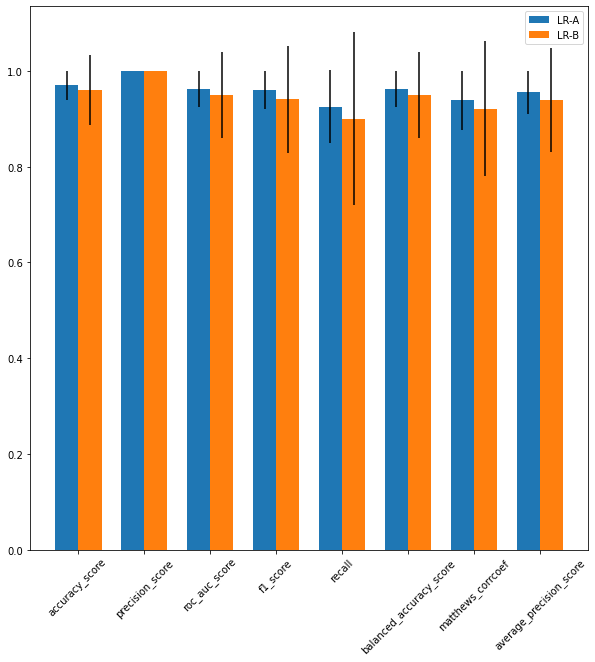

In [74]:
# Calculate Confidence Intervals
tk = 2.776 # (see https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf)
confint_A = {}
confint_B = {}
for k in crossval_scores_A.keys():
    
    confint_A[k] = [
        results_crossval_A_mean[k+'_mean']-tk*results_crossval_A_std[k+'_std']/np.sqrt(n_outer),
        results_crossval_A_mean[k+'_mean']+tk*results_crossval_A_std[k+'_std']/np.sqrt(n_outer)
    ]
    
    confint_B[k] = [
        results_crossval_B_mean[k+'_mean']-tk*results_crossval_B_std[k+'_std']/np.sqrt(n_outer),
        results_crossval_B_mean[k+'_mean']+tk*results_crossval_B_std[k+'_std']/np.sqrt(n_outer)

    ]


labels_metrics = [x for x in confint_A.keys() if 'time' not in x]

plt.rc('font', size=10)

fig, ax = plt.subplots(figsize=(10,10))
ax.bar([x-width/2 for x in np.arange(len(labels_metrics))], 
       [results_crossval_A_mean[x] for x in results_crossval_A_mean.keys() if ('mean' in x) and ('time') not in x], 
       yerr=[tk*results_crossval_A_std[x] for x in results_crossval_A_std.keys() if 'time' not in x]/np.sqrt(n_outer),
       width=0.35, label='LR-A')
ax.bar([x+width/2 for x in np.arange(len(labels_metrics))], 
       [results_crossval_B_mean[x] for x in results_crossval_B_mean.keys() if ('mean' in x) and ('time') not in x], 
       yerr=[tk*results_crossval_B_std[x] for x in results_crossval_B_std.keys() if 'time' not in x]/np.sqrt(n_outer),
       width=0.35, label='LR-B')

plt.legend()
ax.set_xticks(np.arange(len(labels_metrics)))
ax.set_xticklabels([x.split('test_')[1] for x in labels_metrics], rotation=45)

plt.show()

In [75]:
results_crossval_B_mean

{'fit_time_mean': 0.3240202903747559,
 'score_time_mean': 0.03556065559387207,
 'test_accuracy_score_mean': 0.96,
 'test_precision_score_mean': 1.0,
 'test_roc_auc_score_mean': 0.95,
 'test_f1_score_mean': 0.9405128205128206,
 'test_recall_mean': 0.9,
 'test_balanced_accuracy_score_mean': 0.95,
 'test_matthews_corrcoef_mean': 0.9211647630918929,
 'test_average_precision_score_mean': 0.9400000000000001,
 'fit_time_std': 0.047058536434208244,
 'score_time_std': 0.011043650386395437,
 'test_accuracy_score_std': 0.058309518948453015,
 'test_precision_score_std': 0.0,
 'test_roc_auc_score_std': 0.07288689868556626,
 'test_f1_score_std': 0.08944859942734416,
 'test_recall_std': 0.1457737973711325,
 'test_balanced_accuracy_score_std': 0.07288689868556626,
 'test_matthews_corrcoef_std': 0.11399096795938843,
 'test_average_precision_score_std': 0.0874642784226795}

In [76]:
pd.DataFrame(confint_A)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,0.25062,0.014451,0.93959,1.0,0.924488,0.919454,0.848976,0.924488,0.877631,0.909386
1,0.41264,0.044804,1.00041,1.0,1.000512,1.000546,1.001024,1.000512,1.000830,1.000614


In [77]:
pd.DataFrame(confint_B)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,0.265599,0.021850,0.887611,1.0,0.859513,0.829466,0.719027,0.859513,0.779649,0.831416
1,0.382442,0.049271,1.032389,1.0,1.040487,1.051560,1.080973,1.040487,1.062681,1.048584


In [78]:
# Train the best classifier on the entire dataset
clfAbest = clfA.best_estimator_
#clfAbest.coef_
clfBbest = clfB.best_estimator_

### Coefficients of the Logistic Regression (A approach)

In [79]:

pd.DataFrame({'feature':col_A, 'beta':clfAbest.coef_[0]})


,feature,beta
0,nPVS,2.313930
1,nPS,1.447118
2,nPM,4.879939
3,nPP,1.497133
4,nBA,-1.586196
5,nBS,0.000000
6,nBP,-2.035190


In [80]:
pd.DataFrame({'feature':col_A, 'beta':clfAbest.coef_[0]})

,feature,beta
0,nPVS,2.313930
1,nPS,1.447118
2,nPM,4.879939
3,nPP,1.497133
4,nBA,-1.586196
5,nBS,0.000000
6,nBP,-2.035190


### Coefficients of the Logistic Regression (B approach)

In [81]:
pd.set_option('display.max_rows', 60)
pd.DataFrame({'feature':col_B, 'beta':clfBbest.coef_[0]})

,feature,beta
0,nPVS,0.714860
1,nPS,1.025017
2,nPM,0.995560
3,nPP,0.871668
4,nBA,-0.674552
5,nBS,-0.148895
6,nBP,-0.834808
7,stop_gained,0.350536
8,stop_lost,0.000000
9,frameshift_variant,0.392561


In [82]:
pd.set_option('display.max_rows', 60)
pd.DataFrame({'feature':col_B, 'beta':clfBbest.coef_[0]})

,feature,beta
0,nPVS,0.714860
1,nPS,1.025017
2,nPM,0.995560
3,nPP,0.871668
4,nBA,-0.674552
5,nBS,-0.148895
6,nBP,-0.834808
7,stop_gained,0.350536
8,stop_lost,0.000000
9,frameshift_variant,0.392561


In [83]:
cv_cal = 2 #2

clfAbestcal = CalibratedClassifierCV(clfA.best_estimator_, cv=cv_cal, method="sigmoid")
clfAbest.fit(training_df[col_A], y_train_num)

clfBbestcal = CalibratedClassifierCV(clfB.best_estimator_, cv=cv_cal, method="sigmoid")
clfBbest.fit(training_df[col_B], y_train_num)


# ### Test set Analysis
# Now we evaluate the performance on the test set. Moreover, the test set is exploited to 
# tune the classification threshold

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
clfAbestcal.fit(training_df[col_A], y_train_num)
clfBbestcal.fit(training_df[col_B], y_train_num)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.5,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='warn',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=1,
                                                         solver='liblinear',
                                                         tol=0.0001, verbose=0,
                                             

In [85]:
tuning_df

,CHROMOSOME,START,REF,ALT,nPVS,nPS,nPM,nPP,nBA,nBS,...,DBSNP_1TGP_ALT_freq,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot
0,chr10,89692847,T,C,0,0,2,2,0,0,...,0.000000,0.000000,0.996260,0.000000,0.000,0.984,0.845,-1.00,0.984,1
1,chr12,122064774,CCGCCA,-,0,0,0,0,1,0,...,0.999800,0.026106,0.000000,0.000000,0.000,0.084,-1.000,-1.00,0.084,0
2,chr2,73114673,G,A,0,0,0,1,0,0,...,0.000998,0.003795,0.997392,0.000000,0.000,0.170,0.152,0.56,0.403,0
3,chr2,166170413,C,A,0,1,1,3,0,0,...,0.000000,0.000000,0.993601,0.993824,0.846,1.000,0.999,0.00,0.948,0
4,chr6,80878622,C,T,0,1,3,3,0,0,...,0.000000,0.000000,0.999144,0.000000,0.000,1.000,1.000,0.00,0.898,1
5,chr6,129807699,G,C,0,0,0,0,1,0,...,0.584300,0.359988,0.676036,0.000000,0.000,0.000,0.000,0.00,0.000,0
6,chr9,130592079,G,A,1,0,1,1,0,0,...,0.000000,0.000000,0.997117,0.000000,0.000,0.992,-1.000,-1.00,0.992,0
7,chr9,133954693,C,G,0,0,0,0,0,0,...,0.001797,0.002384,0.663642,0.000018,0.000,0.000,0.000,0.00,0.000,0
8,chrX,31196906,TCT,-,0,1,2,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000,1.000,-1.000,-1.00,1.000,0
9,chrX,70389650,C,T,0,0,0,0,0,0,...,0.007947,0.012140,0.683853,0.000000,0.000,0.000,0.000,0.00,0.000,0


In [86]:
tuning_var

,CHROMOSOME,START,REF,ALT,FINAL_CLASSIFICATION
0,chrX,31196906,TCT,-,Pathogenic
1,chrX,70389650,C,T,Benign
2,chr9,130592079,G,A,Pathogenic
3,chr6,129807699,G,C,Benign
4,chr12,122064774,CCGCCA,-,Benign
5,chr2,166170413,C,A,Pathogenic
6,chr9,133954693,C,G,Benign
7,chr2,73114673,G,A,Benign
8,chr6,80878622,C,T,Pathogenic
9,chr10,89692847,T,C,Pathogenic


In [87]:
tuning_df_notnorm = tuning_df.copy()
tuning_df_dataset_norm = scaler.transform(tuning_df[col_A+col_B])
tuning_df[col_A+col_B] = tuning_df_dataset_norm

In [88]:
# First column is the predicted probability that the variant is Benign (1-P(Pathogenic|X))
y_predproba_test_sA = clfAbest.predict_proba(tuning_df[col_A])
y_pred_test_sA = clfAbest.predict(tuning_df[col_A])

y_predproba_test_sB = clfBbest.predict_proba(tuning_df[col_B])
y_pred_test_sB = clfBbest.predict(tuning_df[col_B])



In [89]:
y_tuning_num

[1, 0, 0, 1, 1, 0, 1, 0, 1, 0]

In [90]:
# calibration
print(brier_score_loss(y_tuning_num, y_predproba_test_sA[:,1]))
print(brier_score_loss(y_tuning_num, clfAbestcal.predict_proba(tuning_df[col_A])[:,1]))
print(brier_score_loss(y_tuning_num, y_predproba_test_sB[:,1]))
print(brier_score_loss(y_tuning_num, clfBbestcal.predict_proba(tuning_df[col_B])[:,1]))

0.003108133057801824
0.016472016289140426
0.01490903264910311
0.00771045086785232


As we can see, the brier scores of the calibrated and non-calibrated results are very low. Therefore, we retain uncalibrated models.

### Setting the best threshold for classification on the Tuning dataset

In [91]:
beta = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
        0.7, 0.75, 0.8, 0.85, 0.9, 1, 1.5]
beta_sel = 0.35

prec_A, recall_A, threshold_A = precision_recall_curve(y_tuning_num, y_predproba_test_sA[:,1])
selected_thr_A = dict.fromkeys(beta)
for b in beta:
    beta_q = pow(b, 2)
    Fbeta_A = (1 + beta_q) * prec_A * recall_A / (beta_q * prec_A + recall_A)
    selected_thr_A[b] = threshold_A[np.where(Fbeta_A == np.max(Fbeta_A))[0]][0]

In [92]:
selected_thr_A

{0.1: 0.9345955364294369,
 0.15: 0.9345955364294369,
 0.2: 0.9345955364294369,
 0.25: 0.9345955364294369,
 0.3: 0.9345955364294369,
 0.35: 0.9345955364294369,
 0.4: 0.9345955364294369,
 0.45: 0.9345955364294369,
 0.5: 0.9345955364294369,
 0.55: 0.9345955364294369,
 0.6: 0.9345955364294369,
 0.65: 0.9345955364294369,
 0.7: 0.9345955364294369,
 0.75: 0.9345955364294369,
 0.8: 0.9345955364294369,
 0.85: 0.9345955364294369,
 0.9: 0.9345955364294369,
 1: 0.9345955364294369,
 1.5: 0.9345955364294369}

In [93]:

prec_B, recall_B, threshold_B = precision_recall_curve(y_tuning_num, y_predproba_test_sB[:,1])
selected_thr_B = dict.fromkeys(beta)
for b in beta:
    beta_q = pow(b, 2)
    Fbeta_B = (1 + beta_q) * prec_B * recall_B / (beta_q * prec_B + recall_B)
    selected_thr_B[b] = threshold_B[np.where(Fbeta_B == np.max(Fbeta_B))[0]][0]
selected_thr_B

{0.1: 0.7837746298131915,
 0.15: 0.7837746298131915,
 0.2: 0.7837746298131915,
 0.25: 0.7837746298131915,
 0.3: 0.7837746298131915,
 0.35: 0.7837746298131915,
 0.4: 0.7837746298131915,
 0.45: 0.7837746298131915,
 0.5: 0.7837746298131915,
 0.55: 0.7837746298131915,
 0.6: 0.7837746298131915,
 0.65: 0.7837746298131915,
 0.7: 0.7837746298131915,
 0.75: 0.7837746298131915,
 0.8: 0.7837746298131915,
 0.85: 0.7837746298131915,
 0.9: 0.7837746298131915,
 1: 0.7837746298131915,
 1.5: 0.7837746298131915}

In [94]:
# Pathogenicity Score
prec_ps, recall_ps, threshold_ps = precision_recall_curve(y_tuning_num, calc_patho_score(tuning_df_notnorm))
selected_thr_ps = dict.fromkeys(beta)
for b in beta:
    beta_q = pow(b, 2)
    Fbeta_B = (1 + beta_q) * prec_ps * recall_ps / (beta_q * prec_ps + recall_ps)
    selected_thr_ps[b] = threshold_ps[np.where(Fbeta_B == np.max(Fbeta_B))[0]][0]

In [95]:
selected_thr_ps

{0.1: 6.0,
 0.15: 6.0,
 0.2: 6.0,
 0.25: 6.0,
 0.3: 6.0,
 0.35: 6.0,
 0.4: 6.0,
 0.45: 6.0,
 0.5: 6.0,
 0.55: 6.0,
 0.6: 6.0,
 0.65: 6.0,
 0.7: 6.0,
 0.75: 6.0,
 0.8: 6.0,
 0.85: 6.0,
 0.9: 6.0,
 1: 6.0,
 1.5: 6.0}

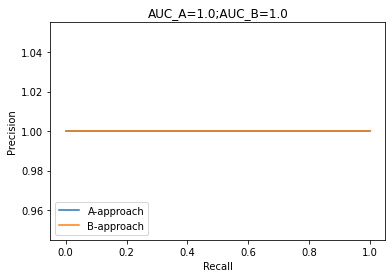

In [96]:
ave_prec_sA = (average_precision_score(y_tuning_num, y_predproba_test_sA[:,1]))
ave_prec_sB = (average_precision_score(y_tuning_num, y_predproba_test_sB[:,1]))


plt.clf()
plt.plot(recall_A, prec_A, label='A-approach')
plt.plot(recall_B, prec_B, label='B-approach')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(label='AUC_A='+str(ave_prec_sA)+';AUC_B='+str(ave_prec_sB))
plt.legend(loc="lower left")
plt.show()

Results on 10% of Clinvitae 2017 (Validation)

In [97]:
test_df_notnorm = test_df.copy()
test_norm_dataset = scaler.transform(test_df[col_A+col_B])
test_df[col_A+col_B] = test_norm_dataset

y_predproba_val_sA = clfAbest.predict_proba(test_df[col_A])
res_lrA_clin2017val = pd.DataFrame.from_dict(get_metrics_fromscores(y_test_num, 
                                              y_predproba_val_sA[:,1], 
                                              selected_thr_A[beta_sel], scoring),
                      orient='index', columns=['LR-A'])

In [98]:
test_df[col_B].describe()

,nPVS,nPS,nPM,nPP,nBA,nBS,nBP,stop_gained,stop_lost,frameshift_variant,...,DBSNP_1TGP_ALT_freq,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot
count,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.0,0.200000,0.066667,0.300000,0.100000,0.100000,0.400000,0.0,0.0,0.0,...,0.016754,0.016691,0.820137,0.000008,0.000434,0.662850,0.654350,0.526000,0.273600,0.200000
std,0.0,0.421637,0.140546,0.366835,0.316228,0.316228,0.262937,0.0,0.0,0.0,...,0.041486,0.026798,0.224204,0.000024,0.001372,0.236011,0.222598,0.073854,0.409291,0.421637
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.405165,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.0,0.0,...,0.000498,0.000234,0.738491,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.333333,0.0,0.0,0.0,...,0.002097,0.000648,0.922141,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.583333,0.000000,0.000000,0.666667,0.0,0.0,0.0,...,0.008885,0.030914,0.992216,0.000000,0.000000,0.907125,0.839750,0.500000,0.453500,0.000000
max,0.0,1.000000,0.333333,1.000000,1.000000,1.000000,0.666667,0.0,0.0,0.0,...,0.134200,0.072868,0.999100,0.000076,0.004338,1.000000,1.000000,0.735000,0.984000,1.000000


In [99]:

y_predproba_val_sB = clfBbest.predict_proba(test_df[col_B])
get_metrics_fromscores(y_test_num, y_predproba_val_sB[:,1], selected_thr_B[beta_sel], scoring)

res_lrB_clin2017val = pd.DataFrame.from_dict(get_metrics_fromscores(y_test_num, 
                                              y_predproba_val_sB[:,1], 
                                              selected_thr_B[beta_sel], scoring),
                      orient='index', columns=['LR-B'])

res_PS_clin2017val = pd.DataFrame.from_dict(get_metrics_fromscores(y_test_num, 
                                                                   calc_patho_score(test_df_notnorm),
                                                                   selected_thr_ps[beta_sel], scoring),
                      orient='index', columns=['PS'])

pd.concat((res_lrA_clin2017val, res_lrB_clin2017val, res_PS_clin2017val), axis=1)

,LR-A,LR-B,PS
accuracy_score,0.900000,0.900000,0.900000
precision_score,1.000000,1.000000,1.000000
roc_auc_score,0.750000,0.750000,0.750000
f1_score,0.666667,0.666667,0.666667
recall,0.500000,0.500000,0.500000
balanced_accuracy_score,0.750000,0.750000,0.750000
matthews_corrcoef,0.666667,0.666667,0.666667
average_precision_score,0.600000,0.600000,0.600000


In [100]:
import pickle

filehandler = open(ROOT_PATH+'clfA.pkl',"wb")
# pickle.dump(clfAbest,filehandler)

filehandler = open(ROOT_PATH+'clfB.pkl',"wb")
# pickle.dump(clfBbest,filehandler)

filehandler = open(ROOT_PATH+'scalerAB.pkl',"wb")
# pickle.dump(scaler,filehandler)

filehandler = open(ROOT_PATH+'scalerA.pkl',"wb")
# pickle.dump(scaler_A,filehandler)

In [101]:
#with open(ROOT_PATH+'col_a.txt', 'w')as o:
#  for c in col_A:
#    o.write(c+'\n')

#with open(ROOT_PATH+'col_b.txt', 'w') as o:
#  for c in col_A:
#    o.write(c+'\n')
#  for c in col_B:
#    o.write(c+'\n')


In [102]:
#with open(ROOT_PATH+'thr.txt', 'w') as o:
#  o.write('THR_A='+str(selected_thr_A[beta_sel])+'\n') 
#  o.write('THR_B='+str(selected_thr_B[beta_sel])+'\n') 

## Validation



### Clinvitae 2019 Dataset

Validate results on Clinvitae 2019 Dataset

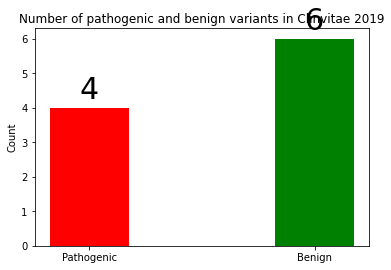

In [103]:
df_clin_2019 = pd.read_csv(ROOT_PATH + 'pubblication_data/subset/clin2019_validation/Clinvitae_2019_dataset_subset.tsv',
                     sep='\t')
c2019_only = df_clin_2019[[x for x in df_clin_2019.columns if x != 'FINAL_CLASSIFICATION']]
y_c2019_only = df_clin_2019['FINAL_CLASSIFICATION']



# Proportions of Pathogenic and Benign in Clinvitae 2019
bars = ('Pathogenic', 'Benign')
y_pos = np.arange(len(bars))


fig, ax = plt.subplots()
rect = ax.bar(y_pos, list(Counter(y_c2019_only).values())[::-1],
        width=0.35,
        color=['r', 'g'])
ax.set_ylabel('Count')
ax.set_title('Number of pathogenic and benign variants in Clinvitae 2019')
plt.xticks(y_pos, bars)
autolabel(rect)
plt.show()

In [104]:
# Bayesian Score
X=2
prior_p = 0.1
odd_pvs = 350
expo = c2019_only['nPP'] / np.power(X,3) + c2019_only['nPM']/ np.power(X, 2) + c2019_only['nPS']/ X + c2019_only['nPVS']
odds = np.power(odd_pvs, expo)
postp = odds*prior_p/((odds-1)*prior_p+1)
ypred_bayes_c2019 = [int(x) for x in postp >= 0.9]#selected_thr_bayes[0.4]]#0.9]

c2019_only_norm = c2019_only.copy()
c2019_only_norm[col_A+col_B] = scaler.transform(c2019_only[col_A+col_B])
ypred_proba_c2019_A = clfAbest.predict_proba(c2019_only_norm[col_A])
ypred_proba_c2019_B = clfBbest.predict_proba(c2019_only_norm[col_B])

ypred_c2019_A = [int(x) for x in ypred_proba_c2019_A[:,1] >= selected_thr_A[beta_sel]]#0.9]#selected_thr_A[0.4]]
ypred_c2019_B = [int(x) for x in ypred_proba_c2019_B[:,1] >= selected_thr_B[beta_sel]]#0.9]#selected_thr_B[0.4]]

# Prediction with eVai
threshold_evai = 3
ypred_evai_c2019 = [int(x) for x in calc_patho_score(c2019_only) > threshold_evai]


evai_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_evai_c2019, scoring)
bayes_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_bayes_c2019, scoring)
lrA_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_c2019_A, scoring)
lrB_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_c2019_B, scoring)


In [105]:
res_clin2019 = pd.concat((pd.DataFrame.from_dict(bayes_scores_c2019.items()),
                          pd.DataFrame.from_dict(evai_scores_c2019.values()),
                          pd.DataFrame.from_dict(lrA_scores_c2019.values()),
                          pd.DataFrame.from_dict(lrB_scores_c2019.values())
                          ),
                         axis=1)
res_clin2019.columns = ['Metric', 'Bayes', 'PS', 'LogA', 'LogB']

In [106]:
res_clin2019

,Metric,Bayes,PS,LogA,LogB
0,accuracy_score,0.800000,1.0,0.800000,0.700000
1,precision_score,1.000000,1.0,1.000000,1.000000
2,roc_auc_score,0.750000,1.0,0.750000,0.625000
3,f1_score,0.666667,1.0,0.666667,0.400000
4,recall,0.500000,1.0,0.500000,0.250000
5,balanced_accuracy_score,0.750000,1.0,0.750000,0.625000
6,matthews_corrcoef,0.612372,1.0,0.612372,0.408248
7,average_precision_score,0.700000,1.0,0.700000,0.550000


#### Perfomance on Variants interpreted as VUS by the ACMG/AMP
Performance on variants interpreted as **VUS** by eVai (according to the ACMG/AMP guidelines)

In [107]:
# Input: df with variants and their levels of evidence (as in the datasets)
def get_acmg_classification(df):
  # For each variant, determine the ACMG/AMP classification
  is_p = df.apply(lambda x: pathogenic_rule(x), axis=1)
  is_lp = df.apply(lambda x: likelypatho_rule(x), axis=1)
  is_b = df.apply(lambda x: benign_rule(x), axis=1)
  is_lb = df.apply(lambda x: likelybenign_rule(x), axis=1)

  # Find VUS, i.e.:
  # 1) Variants with conflicting interpretation
  is_conflict = ((is_p | is_lp) & (is_b | is_lb))
  acmg_class = pd.Series(["VUS"]*df.shape[0])
  np.array(acmg_class)[is_lb] = "LB"
  np.array(acmg_class)[is_b] = "B"
  np.array(acmg_class)[is_lp] = "LP"
  np.array(acmg_class)[is_p] = "P"
  np.array(acmg_class)[is_conflict] = "VUS conflict"

  return acmg_class

In [110]:
c2019_only_prediction = c2019_only.copy()
c2019_only_prediction['PRED_A'] = ypred_c2019_A
c2019_only_prediction['PRED_B'] = ypred_c2019_B
str2int = {'Pathogenic':1, 'Benign':0}
c2019_only_prediction['TRUE_CLASS_NUM'] = [str2int[x] for x in c2019_only_prediction['TRUE_CLASS']]

acmg_class_c2019 = get_acmg_classification(c2019_only_prediction)

In [111]:
c2019_only_prediction

,CHROMOSOME,START,REF,ALT,nPVS,nPS,nPM,nPP,nBA,nBS,...,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot,TRUE_CLASS,PRED_A,PRED_B,TRUE_CLASS_NUM
0,chr5,112080119,A,G,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,Benign,0,0,0
1,chr13,37453479,T,C,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,Benign,0,0,0
2,chr20,30418696,C,A,0.0,0.0,0.0,0.0,0.0,0.0,...,0.174,0.000,0.0,0.0,0.000,0.0,Benign,0,0,0
3,chr16,2120442,G,A,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,Benign,0,0,0
4,chr20,30414528,G,A,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,Benign,0,0,0
5,chr5,89924371,C,G,0.0,0.0,1.0,2.0,0.0,0.0,...,0.924,0.000,0.0,0.0,0.000,0.0,Pathogenic,0,0,1
6,chr19,11211025,A,T,0.0,0.0,1.0,2.0,0.0,0.0,...,0.834,0.000,0.0,0.0,0.000,1.0,Pathogenic,0,0,1
7,chr11,66291398,C,T,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,Benign,0,0,0
8,chr16,28497947,G,C,1.0,1.0,1.0,2.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,Pathogenic,1,0,1
9,chr5,112164664,A,-,1.0,0.0,2.0,1.0,0.0,0.0,...,0.000,0.996,-1.0,-1.0,0.996,1.0,Pathogenic,1,1,1


Classification of Clinvitae Validation according to the ACMG/AMP guidelines

In [112]:
Counter(acmg_class_c2019)

Counter({'VUS': 10})

Therefore, the number of VUS variants in the Clinvitae 2019 dataset is

In [113]:
Counter(acmg_class_c2019)['VUS'] + Counter(acmg_class_c2019)['VUS conflict']

10

In [114]:
# Percentage of VUS
print('Percentage of VUS in Clin2019', (Counter(acmg_class_c2019)['VUS'] + Counter(acmg_class_c2019)['VUS conflict']) / len(acmg_class_c2019))

Percentage of VUS in Clin2019 1.0


In [115]:
# Find VUS variants
iVUS_c2019 = [i for i in range(len(acmg_class_c2019)) if 'VUS' in acmg_class_c2019[i]]

In [116]:
len(iVUS_c2019)

10

In [117]:
y_c2019_only = np.array(y_c2019_only)
# Number of P variants interpreted as VUS
print('% of Pathogenic variants interpreted as VUS', 
      len([i for i in range(len(iVUS_c2019)) if y_c2019_only[iVUS_c2019[i]] == 1])/len(iVUS_c2019))

print('% of Benign variants interpreted as VUS', 
      len([i for i in range(len(iVUS_c2019)) if y_c2019_only[iVUS_c2019[i]] == 0])/len(iVUS_c2019))

% of Pathogenic variants interpreted as VUS 0.4
% of Benign variants interpreted as VUS 0.6


In [118]:

evai_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                         [x for i,x in enumerate(ypred_evai_c2019) if i in iVUS_c2019], 
                                         scoring)
bayes_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                          [x for i,x in enumerate(ypred_bayes_c2019) if i in iVUS_c2019], 
                                          scoring)
lrA_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                        [x for i,x in enumerate(ypred_c2019_A) if i in iVUS_c2019], 
                                        scoring)
lrB_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                        [x for i,x in enumerate(ypred_c2019_B) if i in iVUS_c2019], 
                                        scoring)




In [119]:
res_c2019_onvus = pd.concat((
                          pd.DataFrame.from_dict(evai_scores_onvus.values()),
                          pd.DataFrame.from_dict(bayes_scores_onvus.values()),
                          pd.DataFrame.from_dict(lrA_scores_onvus.values()),
                          pd.DataFrame.from_dict(lrB_scores_onvus.values()),
                          ),
                         axis=1)

res_c2019_onvus.columns = ['PS','Bayes', 'LogA', 'LogB']
res_c2019_onvus.index = list(evai_scores_onvus.keys())

# Results of PS, Bayes score, LR-A and LR-B on variants interpreted as VUS by the ACMG/AMP guidelines
res_c2019_onvus

,PS,Bayes,LogA,LogB
accuracy_score,1.0,0.800000,0.800000,0.700000
precision_score,1.0,1.000000,1.000000,1.000000
roc_auc_score,1.0,0.750000,0.750000,0.625000
f1_score,1.0,0.666667,0.666667,0.400000
recall,1.0,0.500000,0.500000,0.250000
balanced_accuracy_score,1.0,0.750000,0.750000,0.625000
matthews_corrcoef,1.0,0.612372,0.612372,0.408248
average_precision_score,1.0,0.700000,0.700000,0.550000


In [120]:
# Results on the entire set
res_clin2019


,Metric,Bayes,PS,LogA,LogB
0,accuracy_score,0.800000,1.0,0.800000,0.700000
1,precision_score,1.000000,1.0,1.000000,1.000000
2,roc_auc_score,0.750000,1.0,0.750000,0.625000
3,f1_score,0.666667,1.0,0.666667,0.400000
4,recall,0.500000,1.0,0.500000,0.250000
5,balanced_accuracy_score,0.750000,1.0,0.750000,0.625000
6,matthews_corrcoef,0.612372,1.0,0.612372,0.408248
7,average_precision_score,0.700000,1.0,0.700000,0.550000


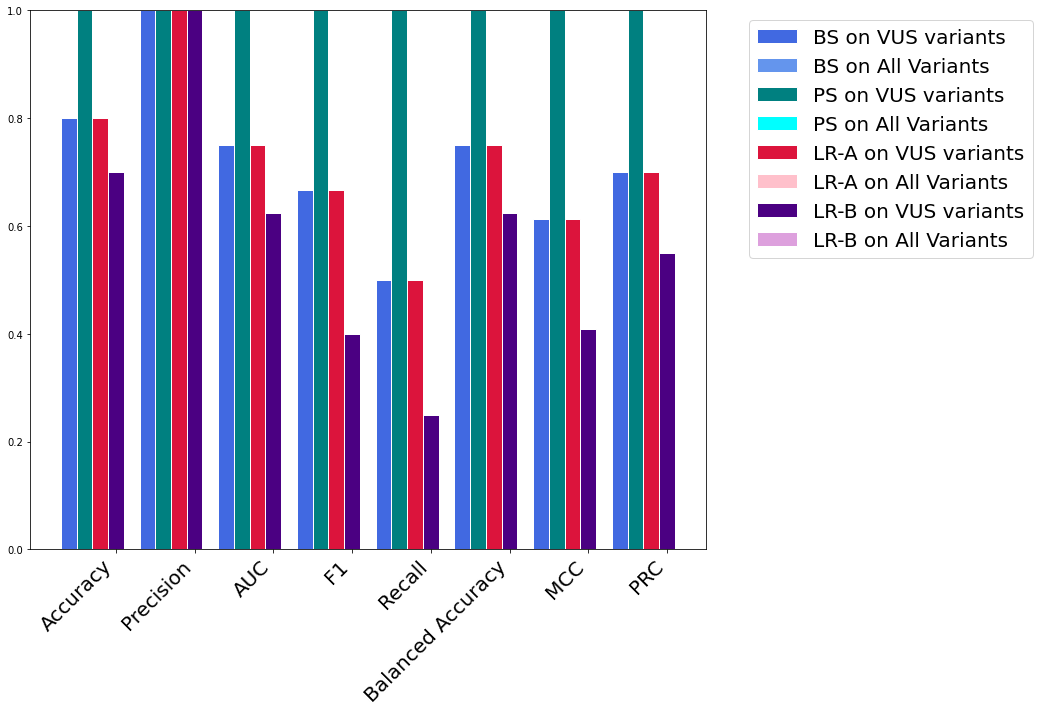

In [121]:
relevant_metrics = ['accuracy_score', 'precision_score', 'roc_auc_score', 'f1_score', 'recall', 'balanced_accuracy_score',
                    'matthews_corrcoef', 'average_precision_score']

labels = ['Accuracy', 'Precision', 'AUC', 'F1', 'Recall', 'Balanced Accuracy', 'MCC', 'PRC']
width = 0.20
r1 = np.arange(len(labels)) 
r2 = [x + width for x in r1] 
r3 = [x + width for x in r2]
r4 = [x + width for x in r3] 

fig, ax = plt.subplots(figsize=(10,10))
bayes_on_vus = res_c2019_onvus.loc[relevant_metrics]['Bayes'].tolist()
ps_on_vus = res_c2019_onvus.loc[relevant_metrics]['PS'].tolist()
lra_on_vus = res_c2019_onvus.loc[relevant_metrics]['LogA'].tolist()
lrb_on_vus = res_c2019_onvus.loc[relevant_metrics]['LogB'].tolist()
# Make the plot
ax.bar(r1, bayes_on_vus , color='royalblue', width=width, edgecolor='white', label='BS on VUS variants')
ax.bar(r1, [res_clin2019[res_clin2019['Metric']==i]['Bayes'].values[0]- res_c2019_onvus.loc[i, 'Bayes'] for i in relevant_metrics],
       width=width, edgecolor='white',color='cornflowerblue', label='BS on All Variants', bottom=bayes_on_vus)

ax.bar(r2, ps_on_vus,  width=width, edgecolor='white', color='teal', label='PS on VUS variants')
ax.bar(r2, [res_clin2019[res_clin2019['Metric']==i]['PS'].values[0]- res_c2019_onvus.loc[i, 'PS'] for i in relevant_metrics],
       width=width, edgecolor='white',color='aqua', label='PS on All Variants', bottom=ps_on_vus)

ax.bar(r3, lra_on_vus,  width=width, edgecolor='white', color='crimson', label='LR-A on VUS variants')
ax.bar(r3, [res_clin2019[res_clin2019['Metric']==i]['LogA'].values[0]- res_c2019_onvus.loc[i, 'LogA'] for i in relevant_metrics],
       width=width, edgecolor='white',color='pink', label='LR-A on All Variants', bottom=lra_on_vus)

ax.bar(r4, lrb_on_vus,  width=width, edgecolor='white', color='indigo', label='LR-B on VUS variants')
ax.bar(r4, [res_clin2019[res_clin2019['Metric']==i]['LogB'].values[0]- res_c2019_onvus.loc[i, 'LogB'] for i in relevant_metrics],
       width=width, edgecolor='white',color='plum', label='LR-B on All Variants', bottom=lrb_on_vus)

 
# Add xticks on the middle of the group bars
ax.set_xticks(r4)
ax.set_xticklabels(labels, ha="right", rotation=45, fontsize=20)

fig.tight_layout()
# Create legend & Show graphic
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [122]:
# Precision-Recall on Clinvitae 2019 (all variants )
pr_A_c2019, rec_A_c2019, thr_A_c2019 = precision_recall_curve(y_c2019_only, ypred_proba_c2019_A[:,1])
pr_B_c2019, rec_B_c2019, thr_B_c2019 = precision_recall_curve(y_c2019_only, ypred_proba_c2019_B[:,1])
pr_Bayes_c2019, rec_Bayes_c2019, thr_Bayes_c2019 = precision_recall_curve(y_c2019_only, postp)
pr_PS_c2019, rec_PS_c2019, thr_PS_c2019 = precision_recall_curve(y_c2019_only, calc_patho_score(c2019_only))

# Precision Recall on Clinvitae 2019 (only VUS variants according to the ACMG)
pr_A_c2019_vus, rec_A_c2019_vus, thr_A_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                                                          [x for i,x in enumerate(ypred_proba_c2019_A[:,1]) if i in iVUS_c2019])
pr_B_c2019_vus, rec_B_c2019_vus, thr_B_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                                                         [ x for i,x in enumerate(ypred_proba_c2019_B[:,1]) if i in iVUS_c2019]
                                                                          )
pr_Bayes_c2019_vus, rec_Bayes_c2019_vus, thr_Bayes_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                                                                      [x for i,x in enumerate(postp) if i in iVUS_c2019]
                                                                                      )
pr_PS_c2019_vus, rec_PS_c2019_vus, thr_PS_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                                                             [x for i,x in enumerate(calc_patho_score(c2019_only)) if i in iVUS_c2019]
                                                                             )


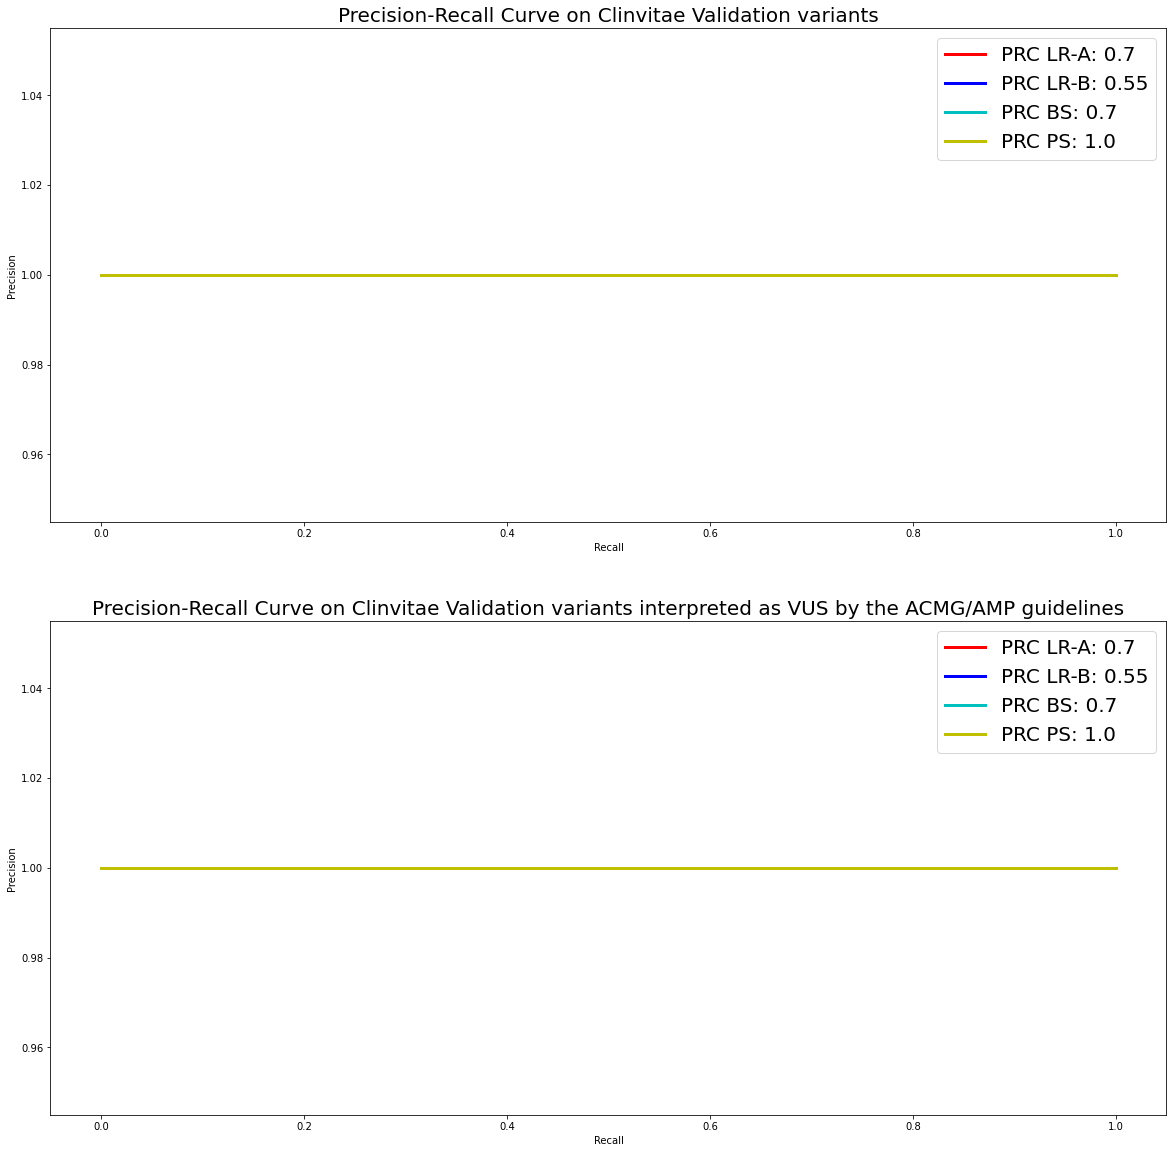

In [123]:
res_c2019_onvus['Metric'] = res_c2019_onvus.index

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
ax[0].plot(rec_A_c2019, pr_A_c2019, c='r', linewidth=3, 
           label='PRC LR-A: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['LogA'].values[0])[0:5])
ax[0].plot(rec_B_c2019, pr_B_c2019, c='b', linewidth=3, 
           label='PRC LR-B: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['LogB'].values[0])[0:5])


ax[0].plot(rec_Bayes_c2019, pr_Bayes_c2019, c='c', linewidth=3, 
           label='PRC BS: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['Bayes'].values[0])[0:5])

ax[0].plot(rec_PS_c2019, pr_PS_c2019, c='y', linewidth=3, 
           label='PRC PS: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['PS'].values[0])[0:5])


ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve on Clinvitae Validation variants',
                fontsize=20)
ax[0].legend(fontsize=20)

ax[1].plot(rec_A_c2019_vus, pr_A_c2019_vus, c='r', linewidth=3, 
           label='PRC LR-A: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['LogA'].values[0])[0:5])
ax[1].plot(rec_B_c2019_vus, pr_B_c2019_vus, c='b', linewidth=3, 
           label='PRC LR-B: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['LogB'].values[0])[0:5])


ax[1].plot(rec_Bayes_c2019_vus, pr_Bayes_c2019_vus, c='c', linewidth=3, 
           label='PRC BS: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['Bayes'].values[0])[0:5])

ax[1].plot(rec_PS_c2019_vus, pr_PS_c2019_vus, c='y', linewidth=3, 
           label='PRC PS: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['PS'].values[0])[0:5])


ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve on Clinvitae Validation variants interpreted as VUS by the ACMG/AMP guidelines', 
                fontsize=20)
ax[1].legend(fontsize=20)


# plt.savefig(ROOT_PATH + 'PRC-C2019.png', dpi=300)
plt.show()


# References
[1] Flygare, S., Hernandez, E.J., Phan, L. et al. The VAAST Variant Prioritizer (VVP): ultrafast, easy to use whole genome variant prioritization tool. BMC Bioinformatics 19, 57 (2018). https://doi.org/10.1186/s12859-018-2056-y

[2] Rentzsch P, Witten D, Cooper GM, Shendure J, Kircher M.
 CADD: predicting the deleteriousness of variants throughout the human genome.
 Nucleic Acids Res. 2018 Oct 29. doi: 10.1093/nar/gky1016.
 PubMed PMID: 30371827. 

 [3] Nicora G, Limongelli I, Gambelli P, Memmi M, Malovini A, Mazzanti A, Napolitano C, Priori S, Bellazzi R.
 Hum Mutat. 2018 Dec;39(12):1835-1846. doi: 10.1002/humu.23665. Epub 2018 Oct 19.PMID:30298955
 
 [4] Mahamdallie S, Ruark E, Holt E, Poyastro-Pearson E, Renwick A, Strydom A, et al. The ICR639 CPG NGS validation series: A resource to assess analytical sensitivity of cancer predisposition gene testing. Wellcome Open Res. 2018;3:68.
 
 [5] Tavtigian SV, Greenblatt MS, Harrison SM, Nussbaum RL, Prabhu SA, Boucher KM, 
 Biesecker LG; ClinGen Sequence Variant Interpretation Working Group (ClinGen
 SVI). Modeling the ACMG/AMP variant classification guidelines as a Bayesian
 classification framework. Genet Med. 2018 Sep;20(9):1054-1060. doi:
 10.1038/gim.2017.210. Epub 2018 Jan 4. PubMed PMID: 29300386; PubMed Central
 PMCID: PMC6336098.